In [1]:
from google.colab import files
uploaded = files.upload()

Saving techniques-classification.parquet to techniques-classification.parquet


In [2]:
!pip install torch transformers pandas numpy scikit-learn fastparquet > /dev/null 2>&1

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import ast

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    multilabel_confusion_matrix
)
from sklearn.preprocessing import MultiLabelBinarizer

In [4]:
# --- Встановлення відтворюваності ---
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
np.random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# --- Завантаження токенізатора ---
tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-conversational', use_fast=True)

# --- Завантаження датасету ---
df = pd.read_parquet('/content/techniques-classification.parquet')
print(f"Dataset loaded: {len(df)} rows")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Dataset loaded: 3822 rows


In [6]:
# Функція для парсингу технік
def safe_parse_techniques(techniques):
    if isinstance(techniques, str):
        try:
            return ast.literal_eval(techniques)
        except:
            return []
    elif isinstance(techniques, np.ndarray):
        return techniques.tolist()
    elif hasattr(techniques, 'tolist'):
        return techniques.tolist()
    elif isinstance(techniques, list):
        return techniques
    else:
        return []

# --- Клас датасету для мультиміткової класифікації ---
class MultiLabelManipulationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, techniques, tokenizer, unique_techniques, max_len=512):
        self.texts = texts
        self.techniques = techniques
        self.tokenizer = tokenizer
        self.unique_techniques = unique_techniques
        self.max_len = max_len
        self.technique_to_idx = {technique: idx for idx, technique in enumerate(self.unique_techniques)}

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        techniques = self.techniques[item]

        # Створюємо multi-hot encoding для всіх технік
        labels = torch.zeros(len(self.unique_techniques))
        for tech in techniques:
            if tech in self.technique_to_idx:
                labels[self.technique_to_idx[tech]] = 1.0

        # Токенізація тексту
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': labels
        }

In [7]:
# --- Функція обчислення метрик для мультиміткової класифікації ---
def compute_metrics(eval_pred, unique_techniques):
    logits, labels = eval_pred
    preds = (torch.sigmoid(torch.tensor(logits)) > 0.5).int().numpy()

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)
    f1 = f1_score(labels, preds, average='macro', zero_division=0)

    # Обчислення confusion matrix для кожної техніки
    confusion_matrices = multilabel_confusion_matrix(labels, preds)

    # Обчислення метрик для кожної техніки окремо
    detailed_metrics = {}
    for i, technique in enumerate(unique_techniques):
        tn, fp, fn, tp = confusion_matrices[i].ravel()
        technique_accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        technique_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        technique_recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        technique_f1 = (
            2 * technique_precision * technique_recall / (technique_precision + technique_recall)
            if (technique_precision + technique_recall) > 0 else 0
        )


        detailed_metrics[technique] = {
            'accuracy': technique_accuracy,
            'precision': technique_precision,
            'recall': technique_recall,
            'f1': technique_f1,
            'tn': int(tn), 'fp': int(fp), 'fn': int(fn), 'tp': int(tp)  # Додано для детального аналізу
        }

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "detailed_metrics": detailed_metrics
    }

# --- Підготовка технік ---
df['techniques_parsed'] = df['techniques'].apply(safe_parse_techniques)

# Отримуємо всі унікальні техніки
unique_techniques = sorted(list(set(
    technique
    for techniques_list in df['techniques_parsed']
    for technique in techniques_list
)))
print(f"Total unique techniques: {len(unique_techniques)}")


Total unique techniques: 10


In [8]:
# --- Розділення даних ---

# Використовуємо MultiLabelBinarizer для створення бінарних міток
mlb = MultiLabelBinarizer(classes=unique_techniques)
mlb.fit(df['techniques_parsed'])
binary_labels = mlb.transform(df['techniques_parsed'])

# Рахуємо кількість входжень кожної комбінації міток
label_counts = pd.DataFrame(binary_labels).value_counts()

# Визначаємо комбінації, які трапляються лише один раз
rare_labels = label_counts[label_counts == 1].index

# Створюємо маску для фільтрації рідкісних міток
mask = np.ones(len(df), dtype=bool)
for rare_label in rare_labels:
    # Перетворюємо rare_label в список, якщо це кортеж
    rare_label_list = list(rare_label)
    # Знаходимо індекси рядків, які відповідають рідкісній комбінації міток
    indices = np.where((binary_labels == rare_label_list).all(axis=1))[0]
    # Виключаємо ці рядки з маски
    mask[indices] = False

# Фільтруємо DataFrame та бінарні мітки
filtered_df = df[mask].reset_index(drop=True)
filtered_binary_labels = binary_labels[mask]

print(f"Original dataset size: {len(df)}")
print(f"Filtered dataset size: {len(filtered_df)}")

Original dataset size: 3822
Filtered dataset size: 3743


In [9]:
# Розділяємо дані, використовуючи stratify=filtered_binary_labels
train_df, val_df = train_test_split(
    filtered_df,
    test_size=0.2,
    random_state=seed,
    stratify=filtered_binary_labels
)

# --- Створення датасетів ---
train_dataset = MultiLabelManipulationDataset(
    train_df['content'].values,
    train_df['techniques_parsed'].values,
    tokenizer,
    unique_techniques
)

val_dataset = MultiLabelManipulationDataset(
    val_df['content'].values,
    val_df['techniques_parsed'].values,
    tokenizer,
    unique_techniques
)

In [10]:
# --- Ініціалізація моделі для мультиміткової класифікації ---
model = AutoModelForSequenceClassification.from_pretrained(
    'DeepPavlov/rubert-base-cased-conversational',
    num_labels=len(unique_techniques),
    problem_type="multi_label_classification",
    ignore_mismatched_sizes=True
).to(device)

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# --- Параметри навчання ---
training_args = TrainingArguments(
    output_dir='checkpoints',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_dir='logs',
    num_train_epochs=30,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    save_total_limit=1,
    logging_steps=50,
    fp16=torch.cuda.is_available(),
    report_to="none",
    logging_first_step=True,
    weight_decay=0.01,
    gradient_accumulation_steps=2,
    warmup_ratio=0.1,
)

# --- Ініціалізація тренера ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: compute_metrics(eval_pred, unique_techniques)
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-12-282f54408498>:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [13]:
# --- Запуск навчання ---
trainer.train()

# --- Збереження моделі ---
trainer.save_model('models')

# --- Отримання результатів ---
metrics = trainer.evaluate()

# --- Виведення результатів ---
print(metrics)

# --- Візуалізація метрик ---
detailed_metrics = metrics['eval_detailed_metrics']

# Створюємо DataFrame для зручного перегляду метрик
metrics_df = pd.DataFrame.from_dict(detailed_metrics, orient='index')
print(metrics_df)

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Detailed Metrics
1,0.347000,0.304330,0.381842,0.073684,0.062304,0.067518,"{'appeal_to_fear': {'accuracy': 0.9305740987983978, 'precision': 0, 'recall': 0.0, 'f1': 0, 'tn': 697, 'fp': 0, 'fn': 52, 'tp': 0}, 'bandwagon': {'accuracy': 0.9666221628838452, 'precision': 0, 'recall': 0.0, 'f1': 0, 'tn': 724, 'fp': 0, 'fn': 25, 'tp': 0}, 'cherry_picking': {'accuracy': 0.8744993324432577, 'precision': 0, 'recall': 0.0, 'f1': 0, 'tn': 655, 'fp': 0, 'fn': 94, 'tp': 0}, 'cliche': {'accuracy': 0.890520694259012, 'precision': 0, 'recall': 0.0, 'f1': 0, 'tn': 667, 'fp': 0, 'fn': 82, 'tp': 0}, 'euphoria': {'accuracy': 0.8851802403204272, 'precision': 0, 'recall': 0.0, 'f1': 0, 'tn': 663, 'fp': 0, 'fn': 86, 'tp': 0}, 'fud': {'accuracy': 0.9092122830440588, 'precision': 0, 'recall': 0.0, 'f1': 0, 'tn': 681, 'fp': 0, 'fn': 68, 'tp': 0}, 'glittering_generalities': {'accuracy': 0.8811748998664887, 'precision': 0, 'recall': 0.0, 'f1': 0, 'tn': 660, 'fp': 0, 'fn': 89, 'tp': 0}, 'loaded_language': {'accuracy': 0.6942590120160214, 'precision': 0.7368421052631579, 'recall': 0.6230366492146597, 'f1': 0.675177304964539, 'tn': 282, 'fp': 85, 'fn': 144, 'tp': 238}, 'straw_man': {'accuracy': 0.9706275033377837, 'precision': 0, 'recall': 0.0, 'f1': 0, 'tn': 727, 'fp': 0, 'fn': 22, 'tp': 0}, 'whataboutism': {'accuracy': 0.9626168224299065, 'precision': 0, 'recall': 0.0, 'f1': 0, 'tn': 721, 'fp': 0, 'fn': 28, 'tp': 0}}"
2,0.275600,0.269466,0.409880,0.228858,0.114881,0.147095,"{'appeal_to_fear': {'accuracy': 0.9305740987983978, 'precision': 0, 'recall': 0.0, 'f1': 0, 'tn': 697, 'fp': 0, 'fn': 52, 'tp': 0}, 'bandwagon': {'accuracy': 0.9666221628838452, 'precision': 0, 'recall': 0.0, 'f1': 0, 'tn': 724, 'fp': 0, 'fn': 25, 'tp': 0}, 'cherry_picking': {'accuracy': 0.8678237650200267, 'precision': 0.3333333333333333, 'recall': 0.05319148936170213, 'f1': 0.09174311926605504, 'tn': 645, 'fp': 10, 'fn': 89, 'tp': 5}, 'cliche': {'accuracy': 0.890520694259012, 'precision': 0, 'recall': 0.0, 'f1': 0, 'tn': 667, 'fp': 0, 'fn': 82, 'tp': 0}, 'euphoria': {'accuracy': 0.8851802403204272, 'precision': 0, 'recall': 0.0, 'f1': 0, 'tn': 663, 'fp': 0, 'fn': 86, 'tp': 0}, 'fud': {'accuracy': 0.9052069425901201, 'precision': 0.43478260869565216, 'recall': 0.14705882352941177, 'f1': 0.2197802197802198, 'tn': 668, 'fp': 13, 'fn': 58, 'tp': 10}, 'glittering_generalities': {'accuracy': 0.9065420560747663, 'precision': 0.7111111111111111, 'recall': 0.3595505617977528, 'f1': 0.4776119402985074, 'tn': 647, 'fp': 13, 'fn': 57, 'tp': 32}, 'loaded_language': {'accuracy': 0.719626168224299, 'precision': 0.8093525179856115, 'recall': 0.5890052356020943, 'f1': 0.6818181818181818, 'tn': 314, 'fp': 53, 'fn': 157, 'tp': 225}, 'straw_man': {'accuracy': 0.9706275033377837, 'precision': 0, 'recall': 0.0, 'f1': 0, 'tn': 727, 'fp': 0, 'fn': 22, 'tp': 0}, 'whataboutism': {'accuracy': 0.9626168224299065, 'precision': 0, 'recall': 0.0, 'f1': 0, 'tn': 721, 'fp': 0, 'fn': 28, 'tp': 0}}"
3,0.252900,0.257769,0.429907,0.374050,0.116439,0.142053,"{'appeal_to_fear': {'accuracy': 0.9305740987983978, 'precision': 0, 'recall': 0.0, 'f1': 0, 'tn': 697, 'fp': 0, 'fn': 52, 'tp': 0}, 'bandwagon': {'accuracy': 0.9666221628838452, 'precision': 0, 'recall': 0.0, 'f1': 0, 'tn': 724, 'fp': 0, 'fn': 25, 'tp': 0}, 'cherry_picking': {'accuracy': 0.8785046728971962, 'precision': 0.6363636363636364, 'recall': 0.07446808510638298, 'f1': 0.13333333333333333, 'tn': 651, 'fp': 4, 'fn': 87, 'tp': 7}, 'cliche': {'accuracy': 0.890520694259012, 'precision': 0, 'recall': 0.0, 'f1': 0, 'tn': 667, 'fp': 0, 'fn': 82, 'tp': 0}, 'euphoria': {'accuracy': 0.8865153538050734, 'precision': 1.0, 'recall': 0.011627906976744186, 'f1': 0.022988505747126436, 'tn': 663, 'fp': 0, 'fn': 85, 'tp': 1}, 'fud': {'accuracy': 0.9038718291054739, 'precision': 0.4, 'recall': 0.11764705882352941, 'f1': 0.1818181818181818, 'tn': 669, 'fp': 12, 'fn': 60, 'tp': 8}, 'glittering_generalities': {'accuracy'

{'eval_loss': 0.4380388855934143, 'eval_accuracy': 0.38050734312416556, 'eval_precision': 0.4285928390053935, 'eval_recall': 0.35144496589156626, 'eval_f1': 0.37676755465781403, 'eval_detailed_metrics': {'appeal_to_fear': {'accuracy': 0.8931909212283045, 'precision': 0.28125, 'recall': 0.34615384615384615, 'f1': 0.3103448275862069, 'tn': 651, 'fp': 46, 'fn': 34, 'tp': 18}, 'bandwagon': {'accuracy': 0.9626168224299065, 'precision': 0.36363636363636365, 'recall': 0.16, 'f1': 0.2222222222222222, 'tn': 717, 'fp': 7, 'fn': 21, 'tp': 4}, 'cherry_picking': {'accuracy': 0.8624833110814419, 'precision': 0.43478260869565216, 'recall': 0.3191489361702128, 'f1': 0.3680981595092025, 'tn': 616, 'fp': 39, 'fn': 64, 'tp': 30}, 'cliche': {'accuracy': 0.8477970627503337, 'precision': 0.16666666666666666, 'recall': 0.0975609756097561, 'f1': 0.12307692307692307, 'tn': 627, 'fp': 40, 'fn': 74, 'tp': 8}, 'euphoria': {'accuracy': 0.8931909212283045, 'precision': 0.5652173913043478, 'recall': 0.30232558139534

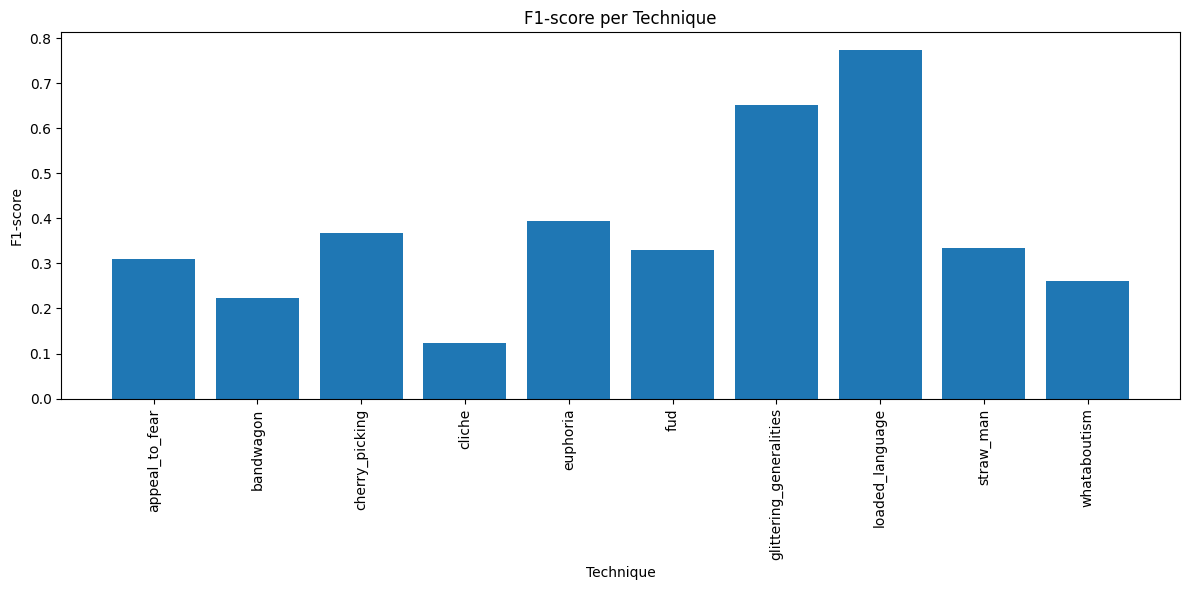

In [14]:
# Побудова графіків (приклад для F1-score)
plt.figure(figsize=(12, 6))
plt.bar(metrics_df.index, metrics_df['f1'])
plt.xlabel('Technique')
plt.ylabel('F1-score')
plt.title('F1-score per Technique')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('f1_scores.png')
plt.show()